# Image Captioning

The project involves use of both NLP and Computer Vision to create a model that can generate description based on the image feeded as the input in the ML model. I have used Flickr30k model to train the deep learning model. The model describes the image in the best possible way

### Importing Libraries

In [1]:
import keras
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

Using TensorFlow backend.


### Getting the files from the drive

In [2]:
from google.colab import drive, files
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
base_dataset_url = 'drive/My Drive/flikr30k/'
os.listdir(base_dataset_url)

['results.csv', 'flickr30k_images', 'x_text.npy', 'y_text.npy']

### Extracting the comments and the image names

In [0]:
df = pd.read_csv(base_dataset_url + "results.csv", sep='|', header=None)
df = df[df[2].notnull()]
df = df[df[0] != 'image_name']
total = 5000
comments = df[2].tolist()[:total]
image_names = df[0].tolist()[:total]

In [0]:
for i in range(len(comments)):
    comments[i] = '<start> ' + comments[i] + ' <end>'

In [6]:
max_length = 0
for i in comments:
    if max_length < len(i):
        max_length = len(i)
print("Max sentence length:", max_length)

Max sentence length: 287


### Finding the unique words

In [0]:
words = []
for sentence in comments:
    words_flag = sentence.split(' ')
    words += words_flag
words = [i.lower() for i in words if i.isalpha()]
unique_words = []
for i in words:
    if i not in unique_words:
        unique_words.append(i)

### Preprocessing the images

In [0]:
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications import VGG16
from keras import models

In [29]:
model = VGG16(include_top = True)
model.layers.pop()
model = models.Model(inputs=model.inputs, outputs=model.layers[-1].output)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [0]:
def preprocess_and_load_image(name):
    image = load_img(base_dataset_url + 'flickr30k_images/' + name, target_size = (224, 224, 3))
    image = img_to_array(image)
    image = preprocess_input(image)
    image = np.array(image).reshape(1, 224, 224, 3)
    y_pred = model.predict(image)
    y_pred = y_pred.flatten()
    return y_pred

In [33]:
images = dict()
iteration = 1
for i in image_names:
    if iteration%1000 == 0:
        print('Iteration: {}'.format(iteration))
    output = preprocess_and_load_image(i)
    images[i] = output
    iteration += 1

Iteration: 1000
Iteration: 2000
Iteration: 3000
Iteration: 4000
Iteration: 5000


In [0]:
shape_image = images['1000268201.jpg'].shape

### Preprocessing Text

In [0]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

number_of_words, max_length = 20000, 50
tokenizer = Tokenizer(number_of_words)
tokenizer.fit_on_texts(comments)
words2index = tokenizer.word_index
index2words = tokenizer.index_word
vocab_size = len(words2index) + 1

In [0]:
x_text, x_image, y_text = [], [], []
comment_sequences = tokenizer.texts_to_sequences(comments)

for comment, image_name in zip(comment_sequences, image_names):
    for i in range(1, len(comment)):
        in_text, out_text = comment[:i], comment[i]
        in_text = pad_sequences([in_text], maxlen = max_length).flatten()
        out_text = to_categorical(out_text, num_classes = vocab_size)
        
        x_image.append(images[image_name])
        x_text.append(in_text)
        y_text.append(out_text)
        

In [0]:
x_image = np.array(x_image)
x_text = np.array(x_text)
y_text = np.array(y_text)

In [0]:
np.save(base_dataset_url + 'x_text.npy', x_text)
np.save(base_dataset_url + 'y_text.npy', y_text)

### Model creation and Training for Image Captioning

In [91]:
from keras import layers, models

input_image = layers.Input(shape = (x_image.shape[1],))
encoded_image = layers.Dense(256, activation = 'relu')(input_image)
input_text = layers.Input(shape = (max_length,))
encoded_text = layers.Embedding(vocab_size, 64, mask_zero = True)(input_text)
encoded_text = layers.LSTM(256)(encoded_text)
decoder = layers.add([encoded_text, encoded_image])
decoder = layers.Dense(256, activation = 'relu')(decoder)
output = layers.Dense(vocab_size, activation = 'softmax')(decoder)
model_image_captioning = models.Model(inputs = [input_text, input_image], outputs = output)

model_image_captioning.compile(loss='categorical_crossentropy', optimizer='adam')
print(model_image_captioning.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 50)           0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 50, 64)       255104      input_12[0][0]                   
__________________________________________________________________________________________________
input_11 (InputLayer)           (None, 4096)         0                                            
__________________________________________________________________________________________________
lstm_5 (LSTM)                   (None, 256)          328704      embedding_5[0][0]                
__________________________________________________________________________________________________
dense_13 (

In [92]:
hist = model_image_captioning.fit([x_text, x_image], y_text, 
                  epochs=1, verbose=2, 
                  batch_size=128,
                  validation_data=([x_text, x_image], y_text))

Train on 66455 samples, validate on 66455 samples
Epoch 1/1
 - 80s - loss: 5.0682 - val_loss: 4.2281


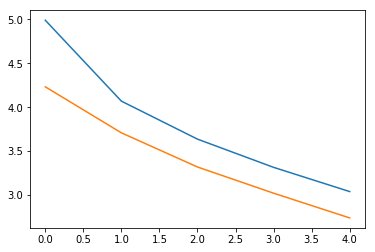

In [53]:
loss = hist.history['loss']
val_loss = hist.history['val_loss']
plt.plot(loss)
plt.plot(val_loss)
plt.show()

### Prediction

 a man in a shirt is is on a street


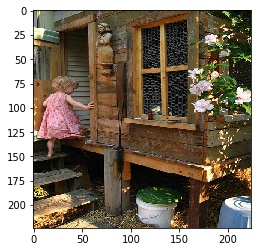

In [117]:
def generate_description(image_name):
    image = load_img(base_dataset_url + 'flickr30k_images/' + image_name, target_size = (224, 224, 3))
    plt.imshow(image)
  
    sentence_generated = 'start'
    for i in range(max_length):
        text = tokenizer.texts_to_sequences([sentence_generated])[0]
        text = pad_sequences([text], maxlen=max_length)
        text = np.array(text).reshape(1,50)
        image = preprocess_and_load_image(image_name)
        image = np.array(image).reshape(1,4096)
        prediction = model_image_captioning.predict([text, image])
        word_index = prediction.argmax()
        word = index2words[word_index]
        sentence_generated += ' {}'.format(word)
        if word == 'end':
            break
    return sentence_generated
        
image_name = '1000268201.jpg'
out = generate_description(image_name).split(' ')
out.remove('start')
out.remove('end')
caption = ''
for i in out:
    caption += ' ' + i
print(caption)